In [ ]:
# Cell 1 — Data loading, train/val/test split, and DataLoader setup (no normalization)

import scipy.io
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

train_mat = scipy.io.loadmat("DigitsDataTrain.mat")
test_mat  = scipy.io.loadmat("DigitsDataTest.mat")

X_train = train_mat["XTrain"]    
y_train = train_mat["anglesTrain"].squeeze()  

X_test  = test_mat["XTest"]       
y_test  = test_mat["anglesTest"].squeeze()   

X_train = np.transpose(X_train, (3, 2, 0, 1))  
X_test  = np.transpose(X_test,  (3, 2, 0, 1))  
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

full_train_ds = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train),
)
test_ds = TensorDataset(
    torch.from_numpy(X_test),
    torch.from_numpy(y_test),
)

n_total   = len(full_train_ds)
n_val     = int(n_total * 0.15)
n_train   = n_total - n_val
train_ds, val_ds = random_split(
    full_train_ds,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 128
train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,     batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,    batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train: {len(train_ds)} samples, Val: {len(val_ds)} samples, Test: {len(test_ds)} samples")


Train: 4250 samples, Val: 750 samples, Test: 5000 samples


✔ Best at epoch 1: Val RMSE=15.3824
✔ Best at epoch 2: Val RMSE=14.0346
✔ Best at epoch 3: Val RMSE=12.1488
✔ Best at epoch 5: Val RMSE=10.7548
✔ Best at epoch 6: Val RMSE=10.6927
✔ Best at epoch 7: Val RMSE=8.7614
✔ Best at epoch 8: Val RMSE=8.3913
✔ Best at epoch 11: Val RMSE=7.3218
✔ Best at epoch 14: Val RMSE=6.8633
✔ Best at epoch 15: Val RMSE=6.8419
✔ Best at epoch 16: Val RMSE=6.7425
✔ Best at epoch 17: Val RMSE=6.6572
✔ Best at epoch 20: Val RMSE=6.4084
✔ Best at epoch 21: Val RMSE=5.7076
✔ Best at epoch 22: Val RMSE=5.7033
✔ Best at epoch 23: Val RMSE=5.6770
✔ Best at epoch 24: Val RMSE=5.6113
✔ Best at epoch 25: Val RMSE=5.6057
✔ Best at epoch 31: Val RMSE=5.5905
✔ Best at epoch 35: Val RMSE=5.5736
✔ Best at epoch 37: Val RMSE=5.5236
✔ Best at epoch 41: Val RMSE=5.5132
✔ Best at epoch 62: Val RMSE=5.5058
✔ Best at epoch 71: Val RMSE=5.5010
✔ Best at epoch 74: Val RMSE=5.4982
✔ Best at epoch 80: Val RMSE=5.4916
✔ Best at epoch 85: Val RMSE=5.4914
✔ Best at epoch 94: Val RMSE=5

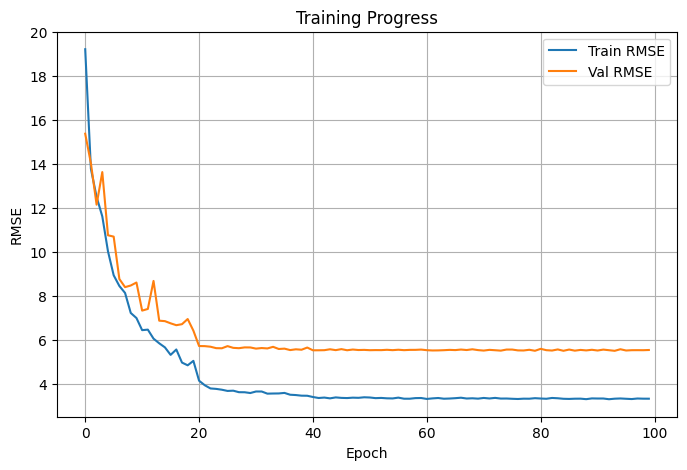

In [4]:

import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

class EnhancedCNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,   8, 3, padding=1), nn.BatchNorm2d(8),  nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,  16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)

model = EnhancedCNNRegressor().to(device)


criterion = nn.MSELoss()                 
def rmse(total_loss, n):                
    return math.sqrt(total_loss / n)

optimizer = optim.SGD(model.parameters(),
                      lr=1e-3,
                      momentum=0.9)      
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=20,   
                                      gamma=0.1)      

num_epochs = 100
train_rmse_history = []
val_rmse_history   = []
best_val_rmse = float('inf')
best_epoch    = -1

for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_mse = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_train_mse += loss.item() * xb.size(0)

    model.eval()
    total_val_mse = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            total_val_mse += criterion(model(xb), yb).item() * xb.size(0)

    train_rmse = rmse(total_train_mse, len(train_loader.dataset))
    val_rmse   = rmse(total_val_mse,   len(val_loader.dataset))
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_epoch    = epoch
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✔ Best at epoch {epoch}: Val RMSE={best_val_rmse:.4f}")

    scheduler.step()

print(f"🏆 Best validation RMSE={best_val_rmse:.4f} at epoch {best_epoch}")

plt.figure(figsize=(8,5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history,   label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()